## Task : Langauge identification from text using recurrent neural network based classifier.<br>
Student : Maria Afara<br>
Dataset : corpus_language_recognition.txt


In [1]:
# imports

import pandas as pd
import numpy as np
import re
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils import shuffle
import pickle
import matplotlib.pyplot as plt
import seaborn as sn

### Data preparation

In [2]:
def process_sentence(sentence):
    """
    Removes all special characters from sentence. It will also strip out
    extra whitespace and makes the string lowercase.
    """
    X="".join(re.findall("[^\W\d_]|\s", sentence.lower().strip(), re.UNICODE))
    X=X.replace("  "," ")
    return X

def letterToIndex(letter,character_set):
    "# Find letter index from all_letters"
    return character_set.index(letter)

def indextoLetter(index,character_set):
    "# Find letter index from all_letters"
    return character_set[index]

def categorytoIndex(category, all_categories):
    return all_categories.index(category)

def indextoCategory(index,all_categories):
    return all_categories[index]


def categoryToTensor(category,all_categories):
    return torch.tensor(categorytoIndex(category), dtype=torch.long)

    
def lineToTensor(line,n_characters,character_set,longest_sentence):
    "# Turn a line into a <line_length x 1 x n_letters>"
    tensor = torch.zeros(longest_sentence,dtype=torch.long)
    for li, letter in enumerate(line):
        tensor[li] = letterToIndex(letter,character_set)
    
    """
    padding (we need to do padding inorder to use batch size larger than 1 in the dataloader because all
    the lines in the matrix should have the same length!)
    """
    
    for li in range(len(line),longest_sentence):
        tensor[li]=letterToIndex('',character_set)
    return tensor

def tensorToLine(tensor,character_set):
    s=''
    for i in tensor:
        s=s+ indextoLetter(i.item(),character_set)
    return s
    
    
# read the corpus into a dataframe
filename="/kaggle/input/dataset/corpus_languge_recognition.txt"
df = pd.read_csv(filename,names=['language_sentence'],sep="\n",header=None)
df[["language","sentence"]] = df["language_sentence"].str.split(" ", 1, expand=True)
data=df[["language","sentence"]]  

#  shuffle the data and prepocess the sentences (the inputs)       
data = shuffle(data)
data["sentence"] = data["sentence"].apply(process_sentence)

def length_sentence(sentence):
    return len(list(sentence))

data["length_sentence"]=data["sentence"].apply(length_sentence)
longest_sentence_length=data["length_sentence"].max()
print(longest_sentence_length)
data=data.drop("length_sentence",1)
data.head()

202


,language,sentence
284570,Dutch,wat gebeurt er met het klimaat
55105,French,et dune maîtrise du langage
356483,Catalan,avui us parlaré
293579,Dutch,de tewaindianen in het zuidwesten hebben een g...
180323,Swedish,de kunde strunta i nördarna


In [3]:
# Get list of all sentences
sentences = [list(str(i)) for i in data['sentence'].tolist()]     
# Collect the characters in the sentences
character_set=set()
        
for s in sentences:
    for c in s:
        character_set.add(c) 
        
character_set.add('')
        
n_characters=len(character_set)
character_set=list(character_set)
        

all_categories=list(data.language.unique())  
        
n_categories=len(all_categories)
        

In [4]:
# # We split the data set into :
# # 60% - train set,
# # 40% - test set,
# # sample frac=1 means all dataset 100%, sometimes i had to use a small fraction of the dataset to work on so i only change the fraction.
# # save the sets into csv files each

# train_dataset, test_dataset = np.split(data.sample(frac=1), [int(.6*len(data)), int(.1*len(data))])

# train_dataset.to_csv("train_dataset.csv",  index=False, columns=["language","sentence"] , sep='\t')
# test_dataset.to_csv("test_dataset.csv",  index=False, columns=["language","sentence"] ,sep='\t')


### 1.Custom dataset, Custom datasetloader

In [5]:
# Custom dataset and dataloader
class LanguageRecognitionDataset(Dataset):
    
    def __init__(self,filename,longest_sentence,n_characters,character_set,all_categories):
        
        self.filename = filename
        data = pd.read_csv(filename,sep="\t")
        self.n_samples=data.shape[0]
        

        x=[]
        y=[]
        
        self.longest_sentence=longest_sentence
        self.n_characters=n_characters
        self.character_set=character_set
        self.all_categories=all_categories
        
        for num, row in data.iterrows():
            
            category_tensor = torch.tensor(all_categories.index(row['language']), dtype=torch.long)
            line_tensor = lineToTensor(str(row['sentence']),n_characters,character_set,self.longest_sentence)
            x.append(line_tensor)
            y.append(category_tensor)

        self.x=x
        self.y=y
        
        
    def __len__(self):
        
        return    self.n_samples

    def __getitem__(self, index):
        
        return self.x[index],self.y[index]
    

In [6]:
batch_size=256

In [7]:
dataset=LanguageRecognitionDataset("/kaggle/input/dataset/train_dataset.csv",longest_sentence_length,n_characters,character_set,all_categories)
train_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [8]:
# pickle.dump(train_loader,open("train_loader.p","wb"))

In [9]:
dataset=LanguageRecognitionDataset("/kaggle/input/dataset/test_dataset.csv",longest_sentence_length,n_characters,character_set,all_categories)
test_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [10]:
# pickle.dump(test_loader,open("test_loader.p","wb"))

In [11]:
# import pickle
# file = open("/kaggle/input/dataset/test_loader.p",'rb')
# test_loader = pickle.load(file)
# file.close()

In [12]:
# file = open("/kaggle/input/dataset/train_loader.p",'rb')
# train_loader = pickle.load(file)
# file.close()

In [13]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 2.Defining hyperparameters

In [14]:
# Hyper-parameters
sequence_length = 202 #dataset.__get_longest_sentence__()
input_size = n_characters #dataset.__get_n_chars__()
embedding_size=100
hidden_size = 512
num_layers = 3
num_classes = n_categories
num_epochs = 10 #10
learning_rate = 0.005

### 3.Defining Neural network model

In [16]:
# Recurrent neural network (many-to-one)
class RNN_LSTM_classifier(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, num_classes, num_direction=1):
        super(RNN_LSTM_classifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_direction = num_direction
        self.embd = nn.Embedding(input_size, embedding_size)
        if self.num_direction == 1:
            self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        else:
            self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*self.num_direction, num_classes)
        self.activation = nn.LogSoftmax(dim=1) #nn.Softmax()
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers*self.num_direction, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers*self.num_direction, x.size(0), self.hidden_size).to(device)
        embedded_x = self.embd(x)
        # Forward propagate LSTM
        out, _ = self.lstm(embedded_x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # Decode the hidden state of the last time step
        out = self.fc(out[:,-1,:])
        act = self.activation(out)

        return act

In [17]:
# defining the model
model = RNN_LSTM_classifier(input_size, embedding_size, hidden_size, num_layers, num_classes,1).to(device)

In [18]:
#  Loss and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

### 4.Training phase

In [19]:
# Train the model
total_step = len(train_loader)
train_loss=[]
epochs=[]
for epoch in range(num_epochs):

    for i, (sentences, languages) in enumerate(train_loader):
        sentences = sentences.reshape(-1, sequence_length).to(device) 
        languages = languages.to(device)
        # Forward pass
        outputs = model(sentences)
        #print(outputs[-1],languages[-1])
        loss = criterion(outputs, languages)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())
    epochs.append(epoch+1)
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
            .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/10], Step [938/938], Loss: 0.5990
Epoch [2/10], Step [938/938], Loss: 0.0497
Epoch [3/10], Step [938/938], Loss: 0.1399
Epoch [4/10], Step [938/938], Loss: 0.0860
Epoch [5/10], Step [938/938], Loss: 0.0406
Epoch [6/10], Step [938/938], Loss: 0.0458
Epoch [7/10], Step [938/938], Loss: 0.0486
Epoch [8/10], Step [938/938], Loss: 0.0260
Epoch [9/10], Step [938/938], Loss: 0.0834
Epoch [10/10], Step [938/938], Loss: 0.0507


### Plotting loss variation over epochs

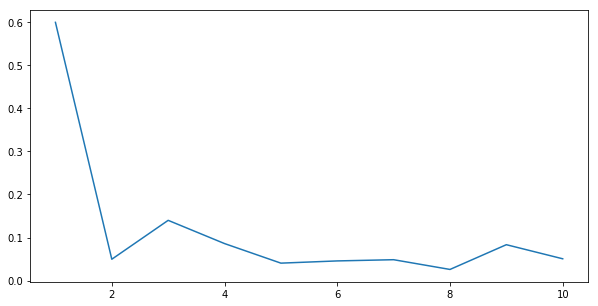

In [20]:
plt.figure(figsize=(10,5))
plt.plot(epochs,train_loss)

### 5.Testing phase

In [21]:
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    for i, (sentences, languages) in enumerate(test_loader):
        sentences = sentences.reshape(-1, sequence_length).to(device)
        languages = languages.to(device)
        outputs = model(sentences)
        _, predicted = torch.max(outputs.data, 1)
        total += languages.size(0)
        correct += (predicted == languages).sum().item()

    print('Test Accuracy of the model on the training set is: {} %'.format(100 * correct / total)) 

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the training set is: 98.1175 %


### 6.Generating results on test dataset and saving the results

In [22]:
# Test the model
df=pd.DataFrame(columns=['sentence',"predicted_langugae","target_language"])
with torch.no_grad():
    for i, (sentences, languages) in enumerate(test_loader):
        sentences = sentences.reshape(-1, sequence_length).to(device)
        languages = languages.numpy()
        outputs = model(sentences)
        _, predicted = torch.max(outputs.data, 1)
        predicted=predicted.cpu().numpy()
        for t in range(sentences.shape[0]):
            s=tensorToLine(sentences[t],character_set)
            target_language=indextoCategory(languages[t],all_categories)
            predicted_language=indextoCategory(predicted[t],all_categories)
            df=df.append({'sentence':s,'predicted_langugae':predicted_language,'target_language':target_language},ignore_index=True)        



In [23]:
df.to_csv("result.csv")

### Plotting confusion matrix

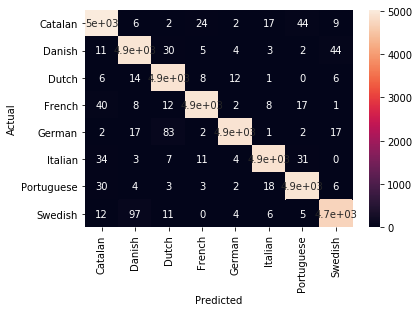

In [24]:
confusion_matrix = pd.crosstab(df['target_language'], df['predicted_langugae'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)